In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture



### Load data

In [2]:
df = pd.read_csv('train-3.csv')
df_test = pd.read_csv('test-4.csv')
df.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,1,0,1,1,0,1,0,0,0,0,...,0,1,1,1,1,1,0,1,1,ALLERGY
1,1,1,0,0,1,0,0,0,1,1,...,1,1,1,0,0,0,0,1,0,FLU
2,1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,ALLERGY
3,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,FLU
4,1,0,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,1,0,FLU


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40007 entries, 0 to 40006
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 40007 non-null  int64 
 1   MUSCLE_ACHES          40007 non-null  int64 
 2   TIREDNESS             40007 non-null  int64 
 3   SORE_THROAT           40007 non-null  int64 
 4   RUNNY_NOSE            40007 non-null  int64 
 5   STUFFY_NOSE           40007 non-null  int64 
 6   FEVER                 40007 non-null  int64 
 7   NAUSEA                40007 non-null  int64 
 8   VOMITING              40007 non-null  int64 
 9   DIARRHEA              40007 non-null  int64 
 10  SHORTNESS_OF_BREATH   40007 non-null  int64 
 11  DIFFICULTY_BREATHING  40007 non-null  int64 
 12  LOSS_OF_TASTE         40007 non-null  int64 
 13  LOSS_OF_SMELL         40007 non-null  int64 
 14  ITCHY_NOSE            40007 non-null  int64 
 15  ITCHY_EYES            40007 non-null

In [4]:
df['TYPE'].value_counts()

TYPE
FLU        22499
ALLERGY    14729
COVID       1849
COLD         930
Name: count, dtype: int64

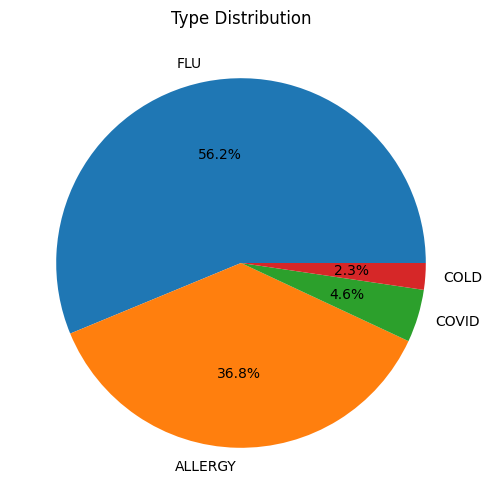

In [5]:
df['TYPE'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title('Type Distribution')
plt.ylabel('')
plt.show()

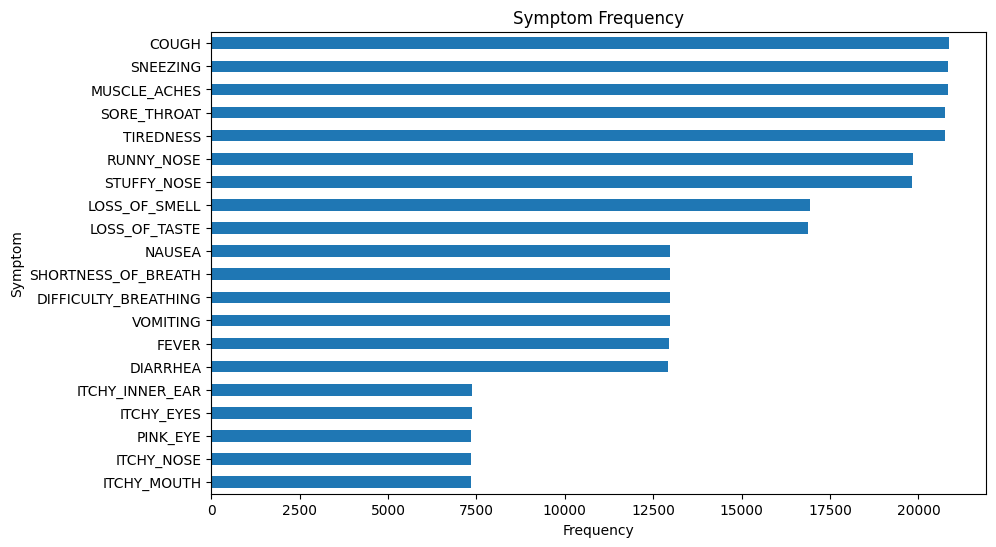

In [6]:
symptom_cols = [col for col in df.columns if col != 'TYPE']
symptom_sums = df[symptom_cols].sum()

symptom_sums.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Symptom Frequency')
plt.xlabel('Frequency')
plt.ylabel('Symptom')
plt.show()

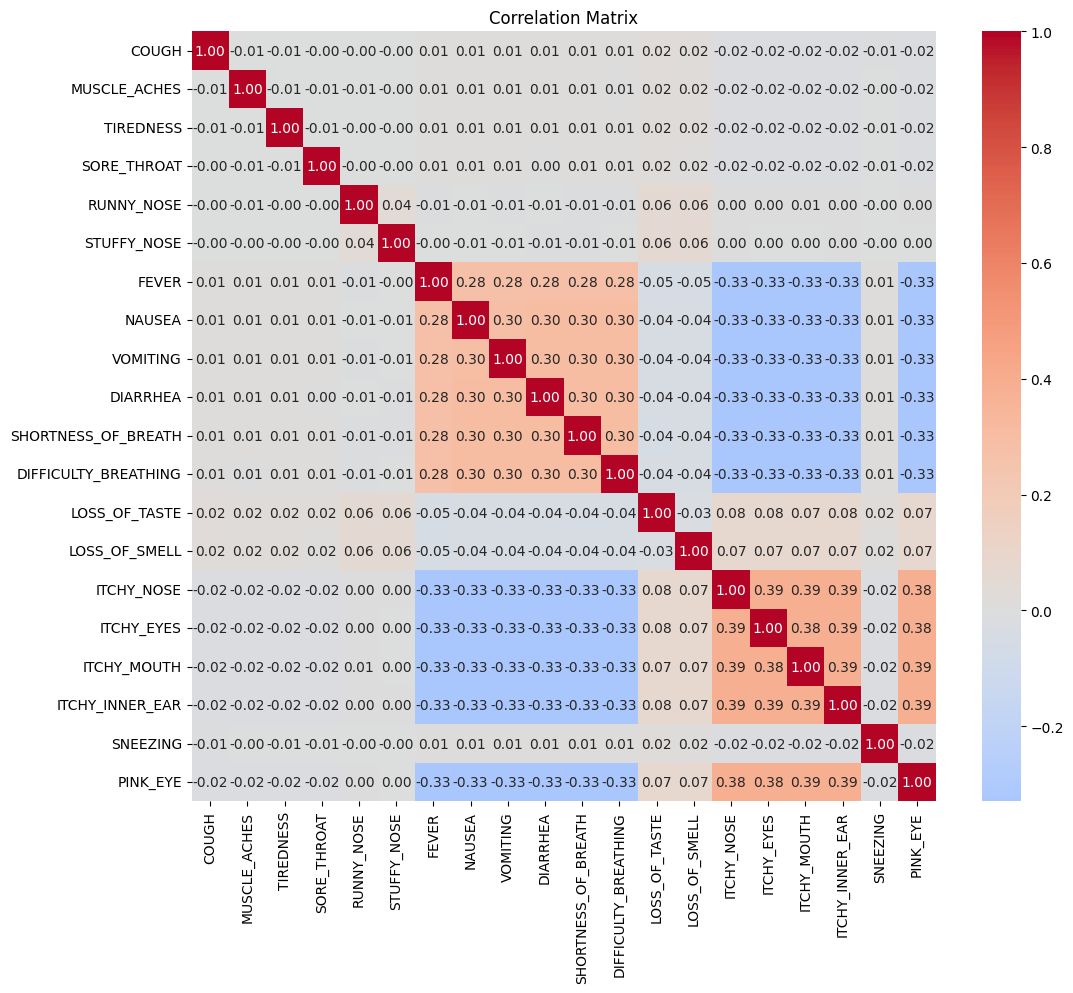

In [7]:
without_type_df = df.drop('TYPE', axis=1)
correlation_matrix = without_type_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')

plt.show()

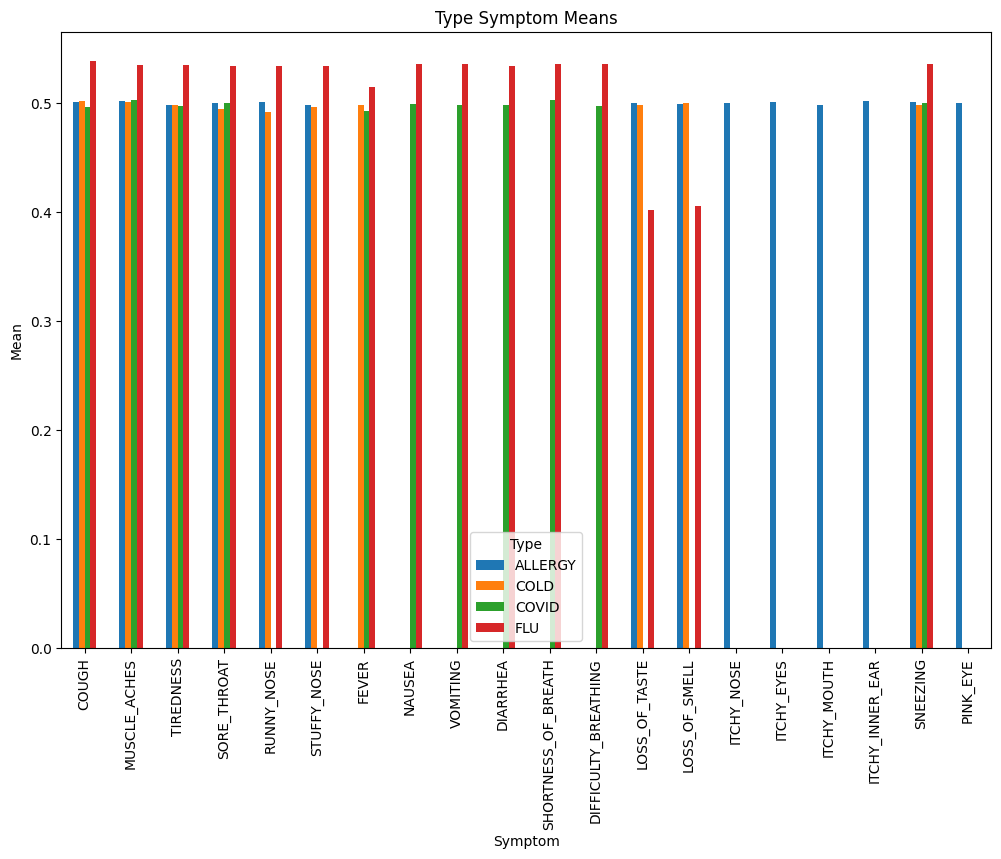

In [8]:
type_symptom_means = df.groupby('TYPE').mean()
type_symptom_means.T.plot(kind='bar', figsize=(12, 8))
plt.title('Type Symptom Means')
plt.xlabel('Symptom')
plt.ylabel('Mean')
plt.legend(title='Type')

plt.show()

## Classification
### Data preprocessing

In [9]:
le = LabelEncoder()
df['TYPE'] = le.fit_transform(df['TYPE'])
df_test['TYPE'] = le.transform(df_test['TYPE'])

X = df.drop('TYPE', axis=1)  # Features
y = df['TYPE']  # Target variable

### Handle imbalanced data

In [10]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Original dataset sample distribution:", Counter(y))
print("Balanced dataset sample distribution:", Counter(y_resampled))

Original dataset sample distribution: Counter({3: 22499, 0: 14729, 2: 1849, 1: 930})
Balanced dataset sample distribution: Counter({0: 22499, 3: 22499, 2: 22499, 1: 22499})


### Split data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

### Model training

In [12]:
rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

### Cross validation

In [13]:
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)
cv_scores_dt = cross_val_score(dt_model, X_train, y_train, cv=5)
print("Random Forest Cross Validation Scores:", cv_scores_rf)
print("Decision Tree Cross Validation Scores:", cv_scores_dt)

Random Forest Cross Validation Scores: [0.95826389 0.95805264 0.95596916 0.95402459 0.95638586]
Decision Tree Cross Validation Scores: [0.95840278 0.95881658 0.95638586 0.95395514 0.95645531]


### Fit models

In [14]:
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train);

### Predictions

In [15]:
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

### Evaluation

In [16]:
print("Random Forest Validation Metrics:")
print(classification_report(y_test, y_pred_rf))

print("Decision Tree Validation Metrics:")
print(classification_report(y_test, y_pred_dt))

Random Forest Validation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4500
           1       0.92      1.00      0.95      4500
           2       0.92      0.96      0.94      4500
           3       1.00      0.91      0.95      4500

    accuracy                           0.96     18000
   macro avg       0.96      0.96      0.96     18000
weighted avg       0.96      0.96      0.96     18000

Decision Tree Validation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4500
           1       0.92      1.00      0.95      4500
           2       0.93      0.96      0.94      4500
           3       1.00      0.91      0.95      4500

    accuracy                           0.96     18000
   macro avg       0.96      0.96      0.96     18000
weighted avg       0.96      0.96      0.96     18000



In [17]:
df_test_scaled_X = pd.DataFrame(
    df_test.drop('TYPE', axis=1),
    columns=df_test.drop('TYPE', axis=1).columns
)
y_pred_rf_test = rf_model.predict(df_test_scaled_X)
y_pred_dt_test = dt_model.predict(df_test_scaled_X)

print("Random Forest Test Metrics:")
print(classification_report(df_test['TYPE'], y_pred_rf_test))

print("Decision Tree Test Metrics:")
print(classification_report(df_test['TYPE'], y_pred_dt_test))

Random Forest Test Metrics:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1652
           1       0.26      0.39      0.31        94
           2       0.17      0.23      0.20       199
           3       0.93      0.89      0.91      2501

    accuracy                           0.88      4446
   macro avg       0.58      0.62      0.60      4446
weighted avg       0.90      0.88      0.89      4446

Decision Tree Test Metrics:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1652
           1       0.26      0.39      0.31        94
           2       0.16      0.20      0.18       199
           3       0.93      0.89      0.91      2501

    accuracy                           0.88      4446
   macro avg       0.58      0.61      0.59      4446
weighted avg       0.90      0.88      0.89      4446



In [18]:
#gb_model = GradientBoostingClassifier(random_state=42)
#param_grid = {
#    'n_estimators': [100, 200],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 7]
#}
#grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
#grid_search.fit(X_resampled, y_resampled)
#print("Best Parameters:", grid_search.best_params_)
#print("Best Accuracy:", grid_search.best_score_)

In [19]:
#best_model = grid_search.best_estimator_
#df_test_scaled_X = pd.DataFrame(
#    df_test.drop('TYPE', axis=1),
#    columns=df_test.drop('TYPE', axis=1).columns
#)

#y_pred_gb = best_model.predict(df_test_scaled_X)
#print("Gradient Boosting Test Metrics:")
#print(classification_report(df_test['TYPE'], y_pred_gb))

## Clustering
### Feature scaling for clustering


In [20]:
# Use original data for clustering, not the balanced one
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Clustering with K-Means


In [21]:
# Find best parameters for K-Means
kmeans_params = {
    'n_clusters': [4],
}

best_silhouette = -1
best_kmeans = None
best_params = None

for n_clusters in kmeans_params['n_clusters']:
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42
    )
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
            
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_kmeans = kmeans
        best_params = {'n_clusters': n_clusters}

print("Best parameters:", best_params)
print("Best silhouette score:", best_silhouette)

kmeans_labels = best_kmeans.fit_predict(X_scaled)


Best parameters: {'n_clusters': 4}
Best silhouette score: 0.054884154502377144


### Clustering with Agglomerative Clustering


In [22]:
agg_params = {
    'n_clusters': [4],
}

best_silhouette = -1
best_agg = None
best_params = None

for n_clusters in agg_params['n_clusters']:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
        
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_agg = agg_clustering
        best_params = {
            'n_clusters': n_clusters, 
        }

print("Best parameters:", best_params)
print("Best silhouette score:", best_silhouette)

agg_labels = best_agg.fit_predict(X_scaled)


Best parameters: {'n_clusters': 4}
Best silhouette score: 0.056853532891807085


### Clustering with Gaussian Mixture Model

In [23]:
gmm_params = {
    'n_components': [4],
}

best_silhouette = -1
best_gmm = None
best_params = None

for n_components in gmm_params['n_components']:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_gmm = gmm
        best_params = {'n_components': n_components}

print("Best parameters:", best_params)
print("Best silhouette score:", best_silhouette)

gmm_labels = best_gmm.fit_predict(X_scaled)

Best parameters: {'n_components': 4}
Best silhouette score: 0.05309947741147106


### Evaluation


In [24]:
print("K-means Silhouette Score:", silhouette_score(X_scaled, kmeans_labels))
print("K-means Adjusted Rand Score:", adjusted_rand_score(y, kmeans_labels))
print("Agglomerative Clustering Silhouette Score:", silhouette_score(X_scaled, agg_labels))
print("Agglomerative Clustering Adjusted Rand Score:", adjusted_rand_score(y, agg_labels))
print("Gaussian Mixture Model Silhouette Score:", silhouette_score(X_scaled, gmm_labels))
print("Gaussian Mixture Model Adjusted Rand Score:", adjusted_rand_score(y, gmm_labels))

K-means Silhouette Score: 0.054884154502377144
K-means Adjusted Rand Score: 0.41942252233961136
Agglomerative Clustering Silhouette Score: 0.056853532891807085
Agglomerative Clustering Adjusted Rand Score: 0.42779966466149927
Gaussian Mixture Model Silhouette Score: 0.05309947741147106
Gaussian Mixture Model Adjusted Rand Score: 0.4389152691432092


### Visualization

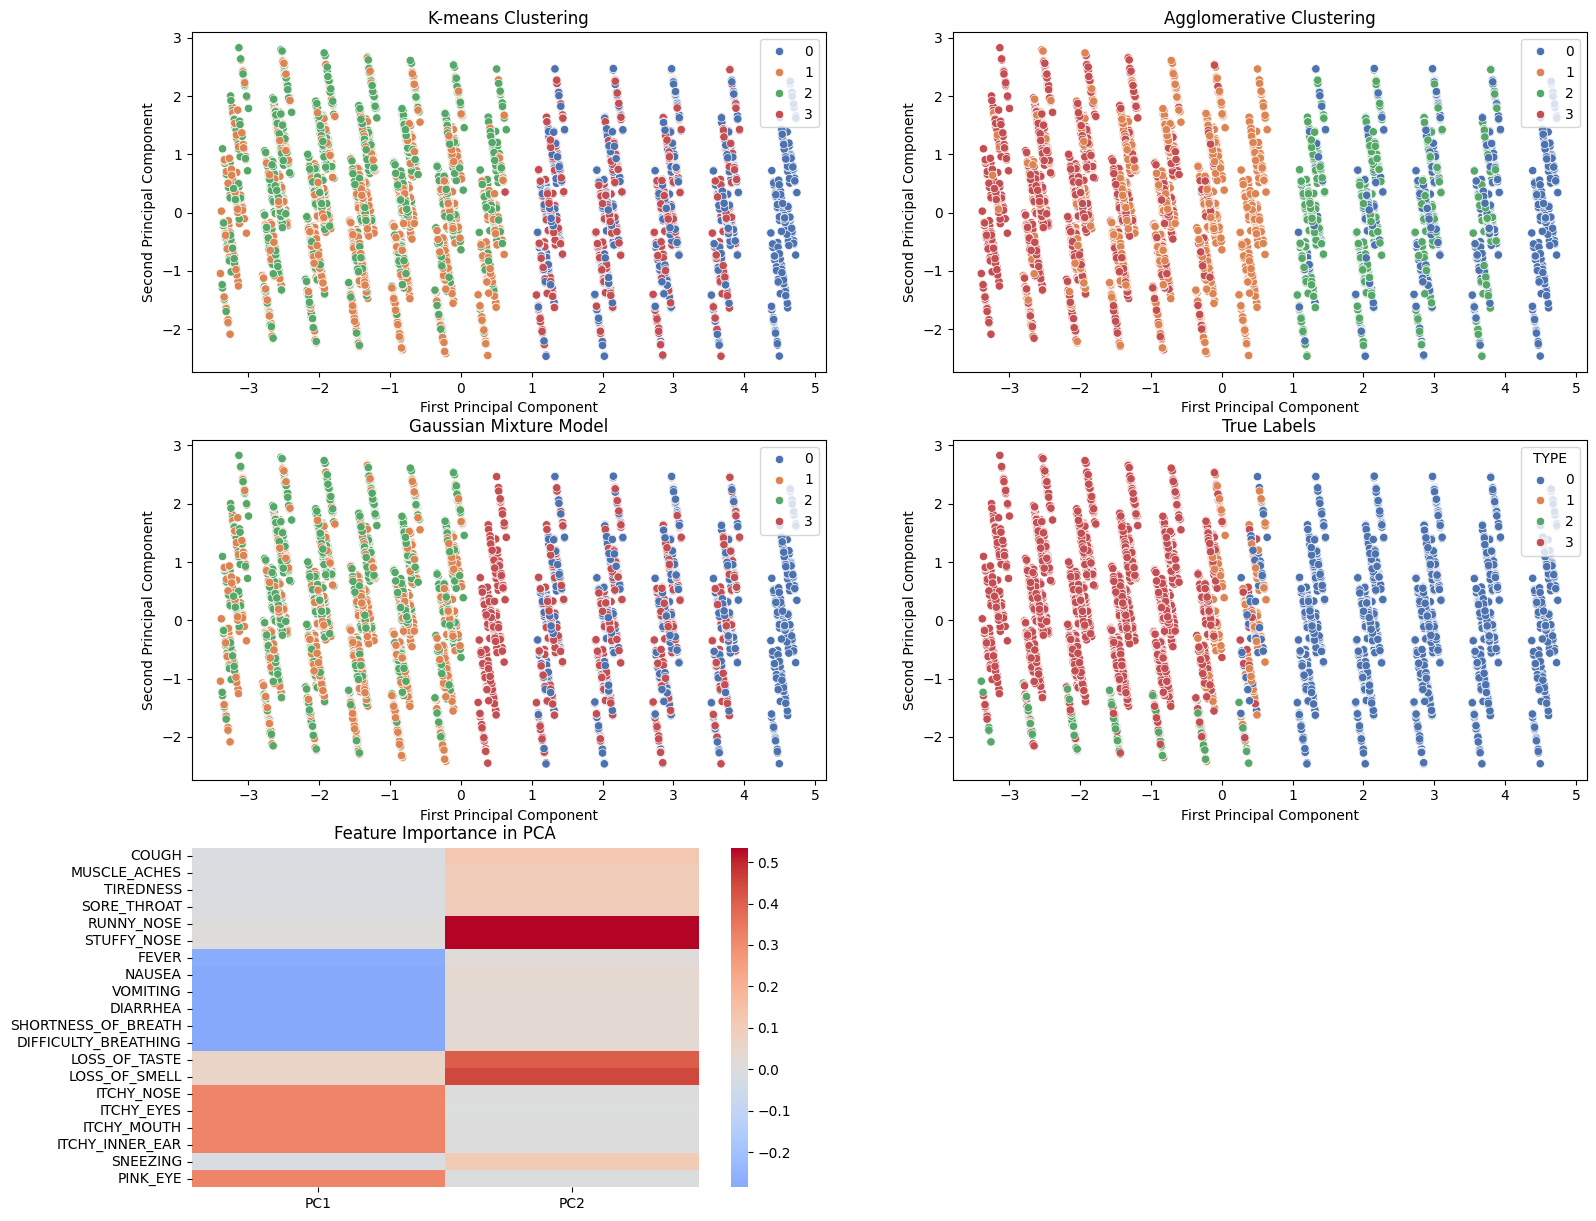

In [25]:
#Dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting
plt.figure(figsize=(18, 15))

# Plot 1: K-means clustering
plt.subplot(3, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='deep')
plt.title('K-means Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 2: Agglomerative Clustering
plt.subplot(3, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_labels, palette='deep')
plt.title('Agglomerative Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 3: Gaussian Mixture Model
plt.subplot(3, 2, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='deep')
plt.title('Gaussian Mixture Model')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 4: True labels
plt.subplot(3, 2, 4)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='deep')
plt.title('True Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 5: Feature importance in PCA
plt.subplot(3, 2, 5)
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)
sns.heatmap(feature_importance, cmap='coolwarm', center=0)
plt.title('Feature Importance in PCA')

plt.show()

In [26]:
def analyze_cluster_composition(true_labels, cluster_labels):
    df_analysis = pd.DataFrame({
        'True_Label': true_labels,
        'Cluster': cluster_labels
    })
    return pd.crosstab(df_analysis['Cluster'], df_analysis['True_Label'], normalize='index')

print("\nK-means Cluster Composition:")
print(analyze_cluster_composition(y, kmeans_labels))

print("\nAgglomerative Clustering Cluster Composition:")
print(analyze_cluster_composition(y, agg_labels))

print("\nGaussian Mixture Model Cluster Composition:")
print(analyze_cluster_composition(y, gmm_labels))


K-means Cluster Composition:
True_Label         0         1         2         3
Cluster                                           
0           1.000000  0.000000  0.000000  0.000000
1           0.017611  0.036152  0.093483  0.852754
2           0.017601  0.036059  0.050156  0.896184
3           0.999856  0.000144  0.000000  0.000000

Agglomerative Clustering Cluster Composition:
True_Label        0         1         2         3
Cluster                                          
0           1.00000  0.000000  0.000000  0.000000
1           0.03701  0.075813  0.067172  0.820005
2           1.00000  0.000000  0.000000  0.000000
3           0.00000  0.000000  0.076123  0.923877

Gaussian Mixture Model Cluster Composition:
True_Label         0         1         2         3
Cluster                                           
0           1.000000  0.000000  0.000000  0.000000
1           0.000000  0.018822  0.096138  0.885040
2           0.000000  0.018834  0.051692  0.929474
3           0.914